<a href="https://colab.research.google.com/github/ethanbrown33/lane_line_detection/blob/main/lane_line_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/adc_data')

import sys
import cv2
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
def load_image(path):
  image = cv2.imread(path)
  image = cv2.resize(image, (1200, 900))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image

def edge_detect(image):
  image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  image_blur = cv2.blur(image, (5, 5))
  image_edge = cv2.Canny(image_blur, 20, 100)

  image_edge_rgb = cv2.cvtColor(image_edge, cv2.COLOR_GRAY2RGB)

  return image_edge_rgb

def histo_peak(histo):
    """Find left and right peaks of histogram"""
    midpoint = int(histo.shape[0]/2)
    leftx_base = np.argmax(histo[:midpoint])
    rightx_base = np.argmax(histo[midpoint:]) + midpoint
    return leftx_base, rightx_base

def get_lane_indices_sliding_windows(binary_warped, leftx_base, rightx_base, n_windows, margin, recenter_minpix):
    """Get lane line pixel indices by using sliding window technique"""
    # Set height of windows
    window_height = int(binary_warped.shape[0]/n_windows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    for window in range(n_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > recenter_minpix:
          leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > recenter_minpix:
          rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    return left_lane_inds, right_lane_inds, nonzerox, nonzeroy

def project_lane_line(original_image, binary_warped, ploty, left_fitx, right_fitx, m_inv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx[:len(ploty)], ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, m_inv, (original_image.shape[1], original_image.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.15, 0)
    return result

def project_measure(original_image, binary_warped, ploty, left_fitx, right_fitx, m_inv, measure_y):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, m_inv, (original_image.shape[1], original_image.shape[0]))

    # Corrected lines to transform the points
    left_unwarp = cv2.perspectiveTransform(np.array([np.column_stack((left_fitx, ploty))], dtype=np.float32), m_inv)[0]
    right_unwarp = cv2.perspectiveTransform(np.array([np.column_stack((right_fitx, ploty))], dtype=np.float32), m_inv)[0]
    ploty_unwarp = cv2.perspectiveTransform(np.array([np.column_stack((np.zeros_like(ploty), ploty))], dtype=np.float32), m_inv)[0][:, 1]

    # find the index of minimum element from the array
    difference_array = np.absolute(ploty_unwarp - measure_y)
    yan = int(difference_array.argmin())
    left_pointx = left_unwarp[yan].astype(int)[0]
    pointy = left_unwarp[yan].astype(int)[1]
    right_pointx = right_unwarp[yan].astype(int)[0]
    bar = 10

    # Draw lines using transformed points
    cv2.line(newwarp, (left_pointx, pointy), (right_pointx, pointy), (255, 0, 0), 5) # line
    cv2.line(newwarp, (left_pointx, pointy + bar), (left_pointx, pointy - bar), (255, 0, 0), 5) # left
    cv2.line(newwarp, (right_pointx, pointy + bar), (right_pointx, pointy - bar), (255, 0, 0), 5) # right
    cv2.line(newwarp, (int((left_pointx + right_pointx) / 2), pointy + bar), (int((left_pointx + right_pointx) / 2), pointy - bar), (255, 0, 0), 5) # middle
    cv2.line(newwarp, (600, measure_y + bar), (600, measure_y - bar), (255, 255, 0), 5) # error


    # calculate ratio
    road_width = 12
    mid = (left_pointx + right_pointx) / 2
    camx = 600

    ratio = (camx - mid) / (right_pointx - left_pointx)
    dist = ratio * 12

    to_left = road_width / 2 + dist
    to_right = road_width / 2 - dist

    cv2.putText(newwarp, "To left: " + str(round(to_left, 3)), (100, 100), cv2.FONT_HERSHEY_COMPLEX, 2, (255, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(newwarp, "To right: " + str(round(to_right, 3)), (100, 200), cv2.FONT_HERSHEY_COMPLEX, 2, (255, 0, 255), 2, cv2.LINE_AA)


    # Combine the result with the original image
    result = cv2.add(original_image, newwarp)
    return result

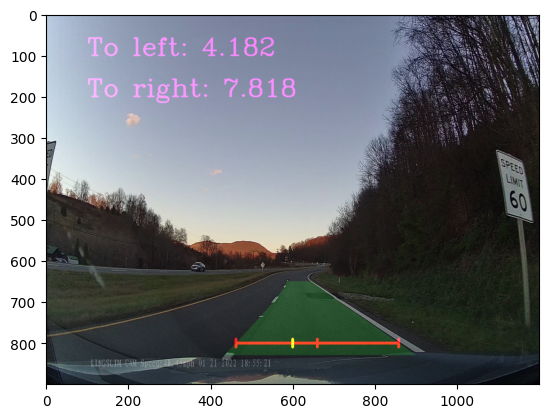

In [12]:
def laneDetector(image):
  image_edge_rgb = edge_detect(image)

  # Warp parameters
  shape = image.shape[::-1][1:]

  offset = 300 # crop inwards?

  upper_bound = 650
  lower_bound = 830
  roi_points = np.float32([
    (550, upper_bound), # Top-left corner
    (300, lower_bound), # Bottom-left corner
    (900, lower_bound), # Bottom-right corner
    (650, upper_bound) # Top-right corner
  ])

  image_points = np.float32([
      [offset, 0],
      [offset, shape[1]],
      [shape[0]-offset, shape[1]],
      [shape[0]-offset, 0]
  ])

  #mask
  mask = np.zeros(image.shape[:2], dtype="uint8")
  cv2.fillPoly(mask, np.int32([roi_points]), (255, 255, 255))
  image_edge_rgb = cv2.bitwise_and(image_edge_rgb, image_edge_rgb, mask=mask)

  # Warp and unwarp matrix calculation
  warp_matrix = cv2.getPerspectiveTransform(roi_points, image_points)
  unwarp_matrix = cv2.getPerspectiveTransform(image_points, roi_points)

  # Warp image
  image_warp = cv2.warpPerspective(image_edge_rgb, warp_matrix, shape, flags=cv2.INTER_LINEAR)
  binary_warped = cv2.cvtColor(image_warp, cv2.COLOR_RGB2GRAY)

  # sliding box parameters
  N_WINDOWS = 32
  MARGIN = 100
  RECENTER_MINPIX = 50

  # Calculate histogram of lane line pixels
  histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

  # Slide boxes
  leftx_base, rightx_base = histo_peak(histogram)
  left_lane_inds, right_lane_inds, nonzerox, nonzeroy = get_lane_indices_sliding_windows(
  binary_warped, leftx_base, rightx_base, N_WINDOWS, MARGIN, RECENTER_MINPIX)

  # Extract left and right line pixel positions
  if len(left_lane_inds) < 2:
      leftx = [offset, offset]
      lefty = [0, shape[1]]
  else:
      leftx = nonzerox[left_lane_inds]
      lefty = nonzeroy[left_lane_inds]

  if len(right_lane_inds) < 2:
      rightx = [shape[0] - offset, shape[0] - offset]
      righty = [0, shape[1]]
  else:
      rightx = nonzerox[right_lane_inds]
      righty = nonzeroy[right_lane_inds]

  # Fit a second order polynomial to each
  left_fit = np.polyfit(lefty, leftx, 2)
  right_fit = np.polyfit(righty, rightx, 2)

  # Generate x and y values for plotting
  ploty = np.linspace(0, image_warp.shape[0]-1, image_warp.shape[0])
  left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
  right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

  lane_line_area_display = image.copy()
  result = project_lane_line(lane_line_area_display, binary_warped, ploty, left_fitx, right_fitx, unwarp_matrix)
  result = project_measure(result, binary_warped, ploty, left_fitx, right_fitx, unwarp_matrix, 800)

  #print(left_fitx)

  return result



# Load image
path = ["challenge_video_frame_1.jpg",
         "harder_challenge_video_frame_10.jpg",
         "frame0.jpg",
         "step0.png"]


image = load_image(path[2])
result = laneDetector(image)
plt.imshow(result)

In [15]:
#vidTest = cv2.VideoCapture("2022_01_21_185522_00.MP4")
#vidTest = cv2.VideoCapture("2021_02_01_203528_00.MP4")
vidTest = cv2.VideoCapture("2021_12_29_223516_00.MP4")

def testRun(numImages):
  #make the output video
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  video_out = cv2.VideoWriter('result.mp4',
                         fourcc, 30, (int(vidTest.get(3)), int(vidTest.get(4))))
  #randint = 0
  vidTest.set(cv2.CAP_PROP_POS_FRAMES, 0)
  for i in tqdm(range(0,numImages)):
    active, img = vidTest.read()
    if active:
      #vdieo testing
      image_resized = cv2.resize(img, (1200, 900))
      image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
      output = laneDetector(image_rgb)
      output_resized = cv2.resize(output, (int(vidTest.get(3)), int(vidTest.get(4))))
      video_out.write(output_resized)

  #output
  video_out.release()
  files.download('result.mp4')

In [16]:
testRun(400)

 12%|█▏        | 49/400 [00:07<01:04,  5.46it/s]<ipython-input-12-b60106d2652b>:68: RankWarning: Polyfit may be poorly conditioned
  right_fit = np.polyfit(righty, rightx, 2)
 12%|█▎        | 50/400 [00:08<01:07,  5.15it/s]<ipython-input-12-b60106d2652b>:67: RankWarning: Polyfit may be poorly conditioned
  left_fit = np.polyfit(lefty, leftx, 2)
<ipython-input-12-b60106d2652b>:68: RankWarning: Polyfit may be poorly conditioned
  right_fit = np.polyfit(righty, rightx, 2)
 13%|█▎        | 51/400 [00:08<01:07,  5.18it/s]<ipython-input-12-b60106d2652b>:67: RankWarning: Polyfit may be poorly conditioned
  left_fit = np.polyfit(lefty, leftx, 2)
<ipython-input-12-b60106d2652b>:68: RankWarning: Polyfit may be poorly conditioned
  right_fit = np.polyfit(righty, rightx, 2)
 13%|█▎        | 52/400 [00:08<01:07,  5.19it/s]<ipython-input-12-b60106d2652b>:67: RankWarning: Polyfit may be poorly conditioned
  left_fit = np.polyfit(lefty, leftx, 2)
<ipython-input-12-b60106d2652b>:68: RankWarning: Polyfi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>